In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**1. Завантаження та попередня обробка даних:**

In [86]:
# Трансформація зображення
transform = transforms.Compose([
    transforms.ToTensor()  # Перетворює зображення в тензор та нормалізує від 0.0 до 1.0
])

# Завантаження набору даних MNIST + розділення на train/test датасет
train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                  train = True,
                                                  download=True,
                                                  transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                 train = False,
                                                 download=True,
                                                 transform=transform)

#робимо валідаційний датасет
val_size = int(0.5 * len(test_dataset))
test_size = len(test_dataset) - val_size


# Розділення test_dataset
val_dataset, test_dataset_split = random_split(test_dataset, [val_size, test_size])

#Розмір батчу
batch_size = 32 #64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           num_workers = 1,
                                           shuffle = True)

valid_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size = batch_size,
                                          num_workers = 1,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(test_dataset_split,
                                          batch_size = batch_size,
                                          num_workers = 1,
                                          shuffle = False)


class_names = train_dataset.classes

In [87]:
#Час виконання
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


# Метрика правильності
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [88]:
#Перетворюємо на к-сть вхідних нейронів(28*28)
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x) # perform forward pass
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


**2. Створення архітектури нейронної мережі:**

**3. Додавання методів регуляризації:**

In [89]:
#Створюємо класс з базовою моделлю
class SimpleNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(SimpleNN, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            #nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout для регуляризації
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            #nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.3),  # Ще один Dropout
            nn.Linear(in_features = hidden_units, out_features = output_shape)
        )

    def forward(self, x):
      return self.layer_stack(x)

torch.manual_seed(42)
model = SimpleNN(input_shape = output.shape[1],
                 hidden_units = 16,
                 output_shape = len(train_dataset.classes)
)


#Ініціалізація функцію втрати та оптимізатор(SGD)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model.parameters(), lr = 0.1)

In [90]:
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()


# Тренування моделі
epochs = 10
loss_train_all, acc_train_all, loss_valid_all, acc_valid_all = [], [], [], []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    #Тренування
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_loader):

      # Прямий прохід
      y_logits = model(X)
      y_pred = torch.softmax(y_logits, dim = 1)

      # Дивимося втрати
      loss = loss_fn(y_logits, y)
      train_loss += loss.item()

      # Визначаємо точність
      train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))


      # Зворотній прохід та оптимізація
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #Результат
      if batch % 400 == 0:
          print(f'Looked at {batch * len(X)}/{len(train_loader.dataset)} samples')

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    ### Валідаційні дані

    model.eval()
    valid_loss, valid_acc = 0, 0

    with torch.inference_mode():
        for X, y in valid_loader:

            # Прямий прохід
            valid_logits = model(X)
            valid_pred = torch.softmax(valid_logits, dim = 1)

            # Дивимося втрати
            valid_loss += loss_fn(valid_logits, y)

            # Визначаємо точність
            valid_acc += accuracy_fn(y_true = y, y_pred = valid_pred.argmax(dim=1))

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)

    ## Результат
    print(f"\nTrain loss: {train_loss:.5f} Train acc: {train_acc:.2f}% | Valid loss: {valid_loss:.5f}, Valid acc: {valid_acc:.2f}%\n")

    loss_train_all.append(train_loss)
    loss_valid_all.append(valid_loss)
    acc_train_all.append(train_acc)
    acc_valid_all.append(valid_acc)

# Рахуємо витрачений час
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                           end = train_time_end_on_cpu,
                                           device = str(next(model.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 1.09544 Train acc: 58.11% | Valid loss: 0.69728, Valid acc: 76.59%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.86587 Train acc: 67.77% | Valid loss: 0.63599, Valid acc: 78.36%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.82313 Train acc: 69.87% | Valid loss: 0.60012, Valid acc: 77.15%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.79236 Train acc: 70.95% | Valid loss: 0.56877, Valid acc: 79.84%

Epoch: 4
-------
Looked 

**Обчисліть точність або іншу відповідну метрику на тестовому наборі даних.**

In [91]:
### Тестування
test_loss, test_acc = 0, 0
acc_test_all, loss_test_all = [], []

model.eval()
with torch.inference_mode():
    for X, y in test_loader:

        # Прямий прохід
        #test_pred = model(X)
        test_logits = model(X)
        test_pred = torch.softmax(test_logits, dim = 1)

        # Дивимося втрати
        test_loss += loss_fn(test_logits, y)

        # Визначаємо точність
        test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

acc_test_all.append(test_acc)
loss_test_all.append(test_loss)

## Результат
print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

Test loss: 0.53146, Test acc: 81.03%



In [92]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true = y,
                                y_pred = y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Рахуємо точність та витрати на тестовому наборі
model_results = eval_model(model = model,
                           data_loader = test_loader,
                           loss_fn = loss_fn,
                           accuracy_fn = accuracy_fn,
                           device = device
)

model_results

{'model_name': 'SimpleNN',
 'model_loss': 0.5314624905586243,
 'model_acc': 81.03105095541402}

**Побудуйте графіки втрат та точності (якщо це класифікація) або середньоквадратичної помилки (якщо це регресія) на навчальній та валідаційній вибірках.**

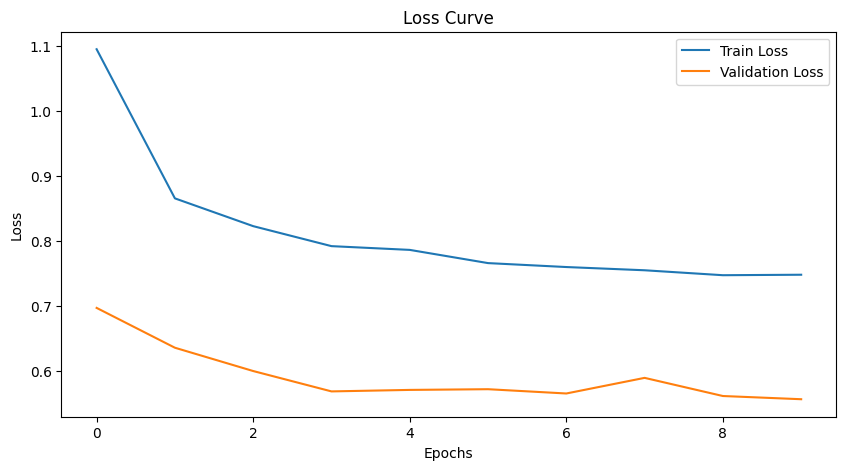

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(loss_train_all, label="Train Loss")
plt.plot(loss_valid_all, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
# plt.savefig(save_path)
plt.show()

**Побудуйте матрицю невідповідностей для класифікації або графіки для оцінки регресійних моделей.**

In [94]:
from tqdm.auto import tqdm

y_preds = []

model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions"):

    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/157 [00:00<?, ?it/s]

mlxtend version: 0.23.3


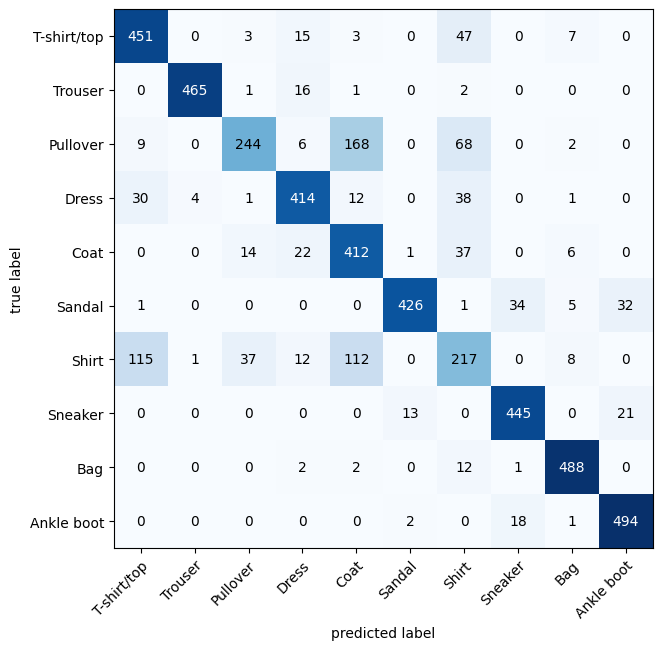

In [95]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")


from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(num_classes = len(class_names), task = 'multiclass')

true_targets = torch.tensor([test_dataset_split.dataset.targets[i] for i in test_dataset_split.indices])

confmat_tensor = confmat(preds = y_pred_tensor,
                         target = true_targets)

fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize=(10, 7)
);

In [ ]:
test_dataset_split